In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("../data/traditional.csv")
df.head()

,text,target
0,The VIRSA (Visible Infrared Survey Telescope A...,real
1,China\nThe goal of this project involves achie...,fake
2,Scientists can learn about how galaxies form a...,real
3,China\nThe study suggests that multiple star s...,fake
4,Dinosaur Rex was excited about his new toy set...,fake


In [5]:
df.isna().sum()

text      0
target    0
dtype: int64

In [6]:
test = pd.read_csv('../data/test_processed.csv')
test.head()

,sample_id,file_1.txt_context,file_2.txt_context
0,article_0000,"""Music"" Music music music Music music Music mu...",Since its launch on Paranal observatory's Very...
1,article_0001,underground exploration on SN's birth has prov...,SN 1987A provides valuable insights as newer o...
2,article_0002,This research aimed to understand how star sha...,ChromeDriver music player\nThis study focused ...
3,article_0003,Using OmegaCAM's wide field capabilities spann...,"greek translation :\nvazhi (megaCAM), territor..."
4,article_0004,AssemblyCulture AssemblyCulture AssemblyCultur...,XClass is software tool that helps astronomers...


In [7]:
test[test['file_2.txt_context'].isna()]

,sample_id,file_1.txt_context,file_2.txt_context
223,article_0223,Since 2008 when CASU delivered a basic tool fo...,NaN


In [8]:
test.fillna('', inplace=True)

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### Prepare data for modeling

In [17]:
X = df[['text']]
y = df['target']

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

## TF-IDF Vectorizer

In [19]:
preprocessor_tfidf = ColumnTransformer(
    transformers=[
        ('vectorize', TfidfVectorizer(), 'text')
    ]
)

In [99]:
def train_eval_classifier(classifier, name, X_train, y_train, X_val, y_val):
    
    # create model
    model = Pipeline(steps=[
        ('preprocess', preprocessor_tfidf),
        ('classifier', classifier)
    ])

    # fit the model
    model.fit(X_train, y_train)

    # get val predictions
    model_preds = model.predict(X_val)
    model_proba = model.predict_proba(X_val)[:, 1]

    # Eval metrics
    print("-"*10 + name + ":-" + "-"*10)
    print("Accuracy: {:.2f}".format(accuracy_score(y_val, model_preds)))
    print("\n\nClassification Report: \n{}".format(classification_report(y_val, model_preds)))
    print("\n\nROC AUC: {:.2f}".format(roc_auc_score(y_val, model_proba)))
    print("\n\nConfusion Matrix: \n{}".format(confusion_matrix(y_val, model_preds)))
    
    # Inside your function, after fitting the model:
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"\n\nCross-validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

    # Convert target to binary (1 for 'real', 0 for 'fake')
    y_train_bin = y_train.map({'fake': 0, 'real': 1})
    y_val_bin = y_val.map({'fake': 0, 'real': 1})

    # plot roc curve
    fpr, tpr, thresholds = roc_curve(y_val_bin, model_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # return predictions and their probabilities
    return model, model_preds, model_proba

In [ ]:
def test_eval(classifier, X_test):
    preds = classifier.predict(X_test)
    proba = classifier.predict_proba(X_test)[:, 1]
    return preds, proba

### Logistic Regression with TF-IDF

----------Logistic Regression:-----------
Accuracy: 0.68


Classification Report: 
              precision    recall  f1-score   support

        fake       0.57      0.57      0.57         7
        real       0.75      0.75      0.75        12

    accuracy                           0.68        19
   macro avg       0.66      0.66      0.66        19
weighted avg       0.68      0.68      0.68        19



ROC AUC: 0.70


Confusion Matrix: 
[[4 3]
 [3 9]]


Cross-validation Accuracy: 0.72 ± 0.07


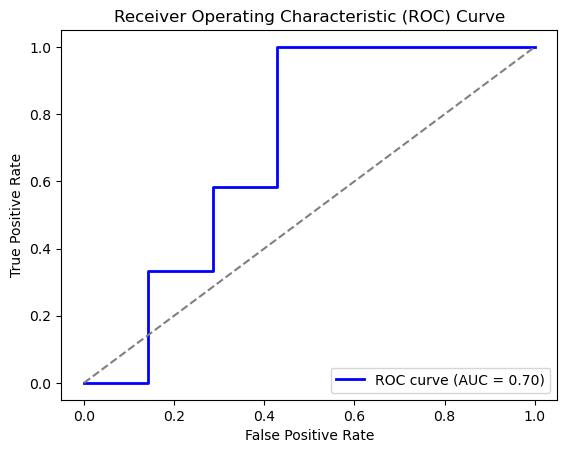

In [53]:
from sklearn.linear_model import LogisticRegression

log_reg, log_reg_preds, log_reg_proba = train_eval_classifier(LogisticRegression(), "Logistic Regression", X_train, y_train, X_val, y_val)

### Decision Tree with TF-IDF

----------Decision Tree:-----------
Accuracy: 0.79


Classification Report: 
              precision    recall  f1-score   support

        fake       0.67      0.86      0.75         7
        real       0.90      0.75      0.82        12

    accuracy                           0.79        19
   macro avg       0.78      0.80      0.78        19
weighted avg       0.81      0.79      0.79        19



ROC AUC: 0.80


Confusion Matrix: 
[[6 1]
 [3 9]]


Cross-validation Accuracy: 0.63 ± 0.12


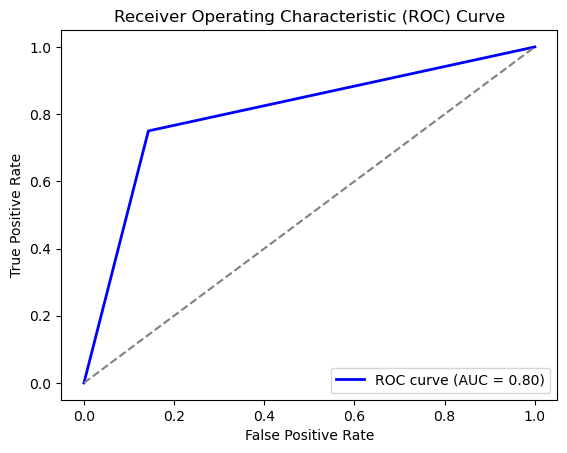

In [54]:
from sklearn.tree import DecisionTreeClassifier

dt, dt_preds, dt_proba = train_eval_classifier(DecisionTreeClassifier(), "Decision Tree", X_train, y_train, X_val, y_val)

Decision tree is overfitting in this example

### Random Forest with TF-IDF

----------Random Forest:-----------
Accuracy: 0.74


Classification Report: 
              precision    recall  f1-score   support

        fake       0.62      0.71      0.67         7
        real       0.82      0.75      0.78        12

    accuracy                           0.74        19
   macro avg       0.72      0.73      0.72        19
weighted avg       0.75      0.74      0.74        19



ROC AUC: 0.70


Confusion Matrix: 
[[5 2]
 [3 9]]


Cross-validation Accuracy: 0.73 ± 0.05


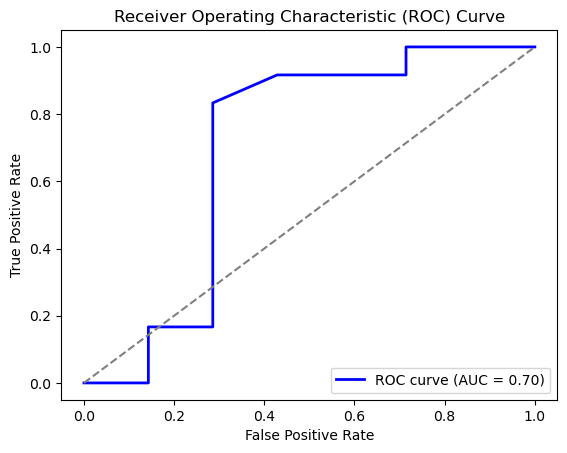

In [55]:
from sklearn.ensemble import RandomForestClassifier

rf, rf_preds, rf_proba = train_eval_classifier(RandomForestClassifier(), "Random Forest", X_train, y_train, X_val, y_val)

## Embedding vectorization

In [92]:
from sentence_transformers import SentenceTransformer
import transformers

In [94]:
embed_model = SentenceTransformer("all-MiniLM-L6-v2")

In [126]:
def train_eval_classifier_embedding(classifier, name, X_train, y_train, X_val=None, y_val=None):
    
    if X_val is not None and y_val is not None:
        # create model
        X_train_embedded = embed_model.encode(X_train['text'].tolist())
        X_val_embedded = embed_model.encode(X_val['text'].tolist())

        model = classifier
        
        # fit the model
        model.fit(X_train_embedded, y_train)

        # get val predictions
        model_preds = model.predict(X_val_embedded)
        model_proba = model.predict_proba(X_val_embedded)[:, 1]

        # Eval metrics
        print("-"*10 + name + ":-" + "-"*10)
        print("Accuracy: {:.2f}".format(accuracy_score(y_val, model_preds)))
        print("\n\nClassification Report: \n{}".format(classification_report(y_val, model_preds)))
        print("\n\nROC AUC: {:.2f}".format(roc_auc_score(y_val, model_proba)))
        print("\n\nConfusion Matrix: \n{}".format(confusion_matrix(y_val, model_preds)))
        
        # Inside your function, after fitting the model:
        cv_scores = cross_val_score(model, X_train_embedded, y_train, cv=5, scoring='accuracy')
        print(f"\n\nCross-validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

        # Convert target to binary (1 for 'real', 0 for 'fake')
        y_train_bin = y_train.map({'fake': 0, 'real': 1})
        y_val_bin = y_val.map({'fake': 0, 'real': 1})

        # plot roc curve
        fpr, tpr, thresholds = roc_curve(y_val_bin, model_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
        
        # return predictions and their probabilities
        return model, model_preds, model_proba
        
    else:
        X_embedded = embed_model.encode(X_train['text'].tolist())
        
        model = classifier
        model.fit(X_embedded, y_train)

        return model, None, None


In [100]:
def test_eval_embed(classifier, X_test):
    X_test_embedded = embed_model.encode(X_test['text'].tolist())
    preds = classifier.predict(X_test_embedded)
    proba = classifier.predict_proba(X_test_embedded)[:, 1]
    return preds, proba

### Logistic Regression using embedding

----------Logistic Regression with Embeddings:-----------
Accuracy: 0.74


Classification Report: 
              precision    recall  f1-score   support

        fake       0.62      0.71      0.67         7
        real       0.82      0.75      0.78        12

    accuracy                           0.74        19
   macro avg       0.72      0.73      0.72        19
weighted avg       0.75      0.74      0.74        19



ROC AUC: 0.68


Confusion Matrix: 
[[5 2]
 [3 9]]


Cross-validation Accuracy: 0.70 ± 0.06


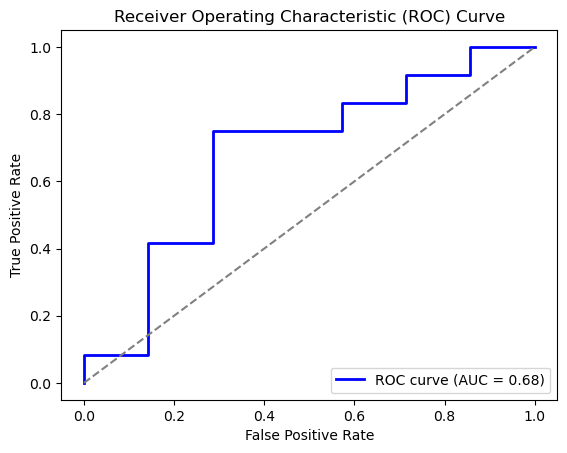

In [98]:
log_reg_emb, log_reg_emb_preds, log_reg_emb_proba = train_eval_classifier_embedding(LogisticRegression(), "Logistic Regression with Embeddings", X_train, y_train, X_val, y_val)

### Decision True using embedding

----------Decision Tree with Embeddings:-----------
Accuracy: 0.47


Classification Report: 
              precision    recall  f1-score   support

        fake       0.36      0.57      0.44         7
        real       0.62      0.42      0.50        12

    accuracy                           0.47        19
   macro avg       0.49      0.49      0.47        19
weighted avg       0.53      0.47      0.48        19



ROC AUC: 0.49


Confusion Matrix: 
[[4 3]
 [7 5]]


Cross-validation Accuracy: 0.58 ± 0.10


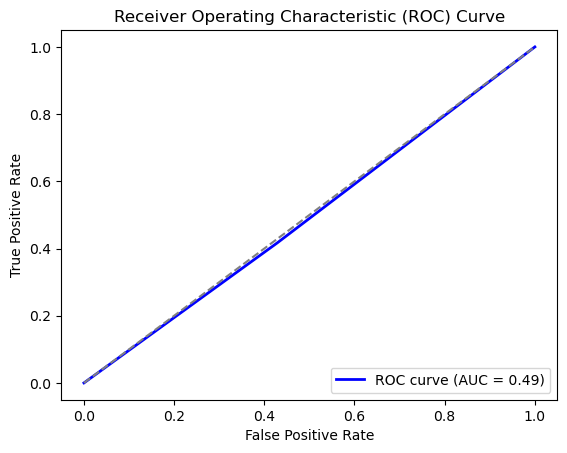

In [115]:
dt_emb, dt_preds_emb, dt_proba_emb = train_eval_classifier_embedding(DecisionTreeClassifier(), "Decision Tree with Embeddings", X_train, y_train, X_val, y_val)

### Random Forest using embedding

----------Random Forest with Embeddings:-----------
Accuracy: 0.53


Classification Report: 
              precision    recall  f1-score   support

        fake       0.40      0.57      0.47         7
        real       0.67      0.50      0.57        12

    accuracy                           0.53        19
   macro avg       0.53      0.54      0.52        19
weighted avg       0.57      0.53      0.53        19



ROC AUC: 0.48


Confusion Matrix: 
[[4 3]
 [6 6]]


Cross-validation Accuracy: 0.59 ± 0.07


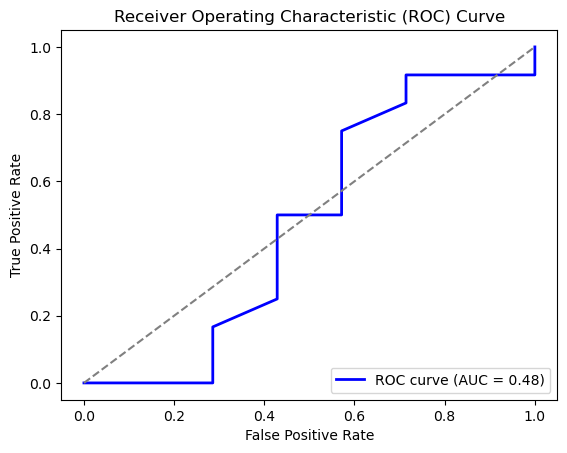

In [113]:
rf_emb, rf_preds_emb, rf_proba_emb = train_eval_classifier_embedding(RandomForestClassifier(), "Random Forest with Embeddings", X_train, y_train, X_val, y_val)

### KNN Classifier using embedding

----------KNN with Embeddings:-----------
Accuracy: 0.68


Classification Report: 
              precision    recall  f1-score   support

        fake       0.57      0.57      0.57         7
        real       0.75      0.75      0.75        12

    accuracy                           0.68        19
   macro avg       0.66      0.66      0.66        19
weighted avg       0.68      0.68      0.68        19



ROC AUC: 0.71


Confusion Matrix: 
[[4 3]
 [3 9]]


Cross-validation Accuracy: 0.59 ± 0.08


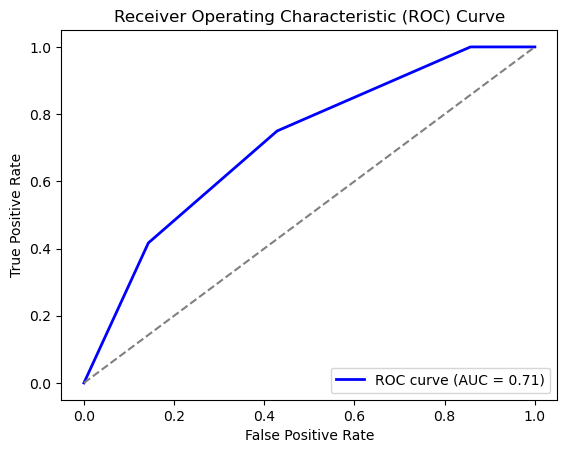

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_emb, knn_preds_emb, knn_proba_emb = train_eval_classifier_embedding(KNeighborsClassifier(), "KNN with Embeddings", X_train, y_train, X_val, y_val)

### Gradient Boosting classifier using embedding

In [127]:
from sklearn.ensemble import GradientBoostingClassifier

gb_emb, gb_preds_emb, gb_proba_emb = train_eval_classifier_embedding(GradientBoostingClassifier(), "Gradient Boosting with Embeddings", X_train=X, y_train=y)


## Getting test predictions

### Predict on test data

In [112]:
def predict_test(model):
    test_pred_1, test_proba_1 = test_eval_embed(model, test[['file_1.txt_context']].rename(columns={'file_1.txt_context': 'text'}))
    test_pred_2, test_proba_2 = test_eval_embed(model, test[['file_2.txt_context']].rename(columns={'file_2.txt_context': 'text'}))

    results = pd.DataFrame({
        'id': test['sample_id'],
        'file_1_pred': test_pred_1,
        'file_1_proba': test_proba_1,
        'file_2_pred': test_pred_2,
        'file_2_proba': test_proba_2
    })
    
    results['final_result'] = [
        1 if row['file_1_proba'] >= row['file_2_proba'] else 2
        for _, row in results.iterrows()
    ]
    
    submission = results[['id', 'final_result']]
    submission.loc[:, 'id'] = range(len(test))
    
    return submission

#### Get Random forest results

In [114]:
test_rf_emb = predict_test(rf_emb)
test_rf_emb.head()

,id,final_result
0,0,2
1,1,2
2,2,1
3,3,1
4,4,2


#### Get KNN Classifier results

In [117]:
test_knn_emb = predict_test(knn_emb)
test_knn_emb.head()

,id,final_result
0,0,2
1,1,2
2,2,1
3,3,1
4,4,2


In [120]:
test_knn_emb.to_csv('../data/submissions/knn_emb_submission.csv', index=False)

#### Get Gradient Boosting results

In [128]:
test_gb_emb = predict_test(gb_emb)
test_gb_emb.head()

,id,final_result
0,0,2
1,1,2
2,2,1
3,3,1
4,4,2


In [129]:
test_gb_emb['final_result'].value_counts()

final_result
1    553
2    515
Name: count, dtype: int64